In [1]:
import logging
import torch
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='Combined_loss_model_on_a(time)_1.log', mode='a')
logger.addHandler(fhandler)

In [2]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch
import torchvision
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from focal_loss.focal_loss import FocalLoss

In [3]:
train_path = "/home/kusum/Desktop/Dataset A/Train" 
test_path = "/home/kusum/Desktop/Dataset A/Test"

In [4]:
train_ds = ImageFolder(train_path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((512,512))]))
test_ds = ImageFolder(test_path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((512,512))]))

In [5]:
len_train = len(train_ds)
len_test = len(test_ds)
len_train, len_test

(3600, 1256)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [7]:
device = get_default_device()
device

device(type='cuda')

In [8]:
class convnet(nn.Module):
    def __init__(self):
        super(convnet, self).__init__()
        #shape=20, 3, 512, 512
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 16, 512, 512
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2,2))
        self.norm1 = nn.BatchNorm2d(16)
        #shape=20, 16, 256, 256

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 32, 256, 256
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((2,2))
        #shape=20, 32, 128, 128        
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 64, 128, 128
        self.relu3 = nn.ReLU()
        self.drop = nn.Dropout2d(p=0.2)
       
        
        self.fc1 = nn.Linear(in_features= 64*128*128, out_features=100)
        self.fc2 = nn.Linear(in_features= 100, out_features=2)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.norm1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)
    
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.drop(output)
        
      
        output = output.view(-1, 64*128*128)
        output = self.fc1(output)
        output = self.fc2(output)
       
        return output
        

In [9]:
torch.cuda.empty_cache()

In [10]:
model = convnet().to(device)
model

convnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1048576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [11]:
loss_fn1 = CrossEntropyLoss()
loss_fn2 = FocalLoss(gamma=2)
optimizer = Adam(model.parameters(), lr = 0.0003, weight_decay = 0.001)

In [12]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, pin_memory=True, shuffle=True)

In [13]:
from time import time 
from tqdm import tqdm 
Train_accuracy = []
Train_loss = []
Val_loss = []
Val_accuracy = []
best_loss = 0
for epoch in range(90):
    train_acc = 0
    start1 = time()
    
    # Train
    model.train()
    
    with tqdm(train_dl, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimizer.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            loss1 = loss_fn1(train_prob, ytrain)
            m = torch.nn.Softmax(dim = -1)
            loss2 = loss_fn2(m(train_prob), ytrain)
        
            loss = loss1 + (0.01*loss2)
         
            loss.backward()
            optimizer.step()
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            #Train_loss.append(loss.item())
            train_acc += int(torch.sum(train_pred == ytrain))
           
    
        Train_loss.append(loss.item())    
        ep_tr_acc = train_acc / len_train
        Train_accuracy.append(ep_tr_acc)
    end1 = time()   
    
    #Model test-
    start2 = time()
    model.eval()
    test_acc = 0
    with torch.no_grad():
        for xtest, ytest in test_dl:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_loss1 = loss_fn1(test_prob, ytest)
            
            m = torch.nn.Softmax(dim = -1)
            test_loss2 = loss_fn2(m(test_prob), ytest)
        
            test_loss = test_loss1 + (0.01*test_loss2)
            #Val_loss.append(test_loss.item())
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
        
            
        Val_loss.append(test_loss.item())   
        ep_test_acc = test_acc / len_test
        Val_accuracy.append(ep_test_acc)

    if(epoch % 8 == 0):
        torch.save(model.state_dict(), "Best_combined_loss_onA(time)_1" + str(epoch))
        
    end2 = time()
    duration1 = (end1 - start1) / 60
    duration2 = (end2 - start2) / 60

    print(f"Epoch: {epoch}, Time for one epoch for training: {duration1} \n Train_Loss: {loss}, Train_accuracy: {ep_tr_acc} \n Test_loss:{test_loss}, Test_accuracy:{ep_test_acc}, Test_duration:{duration2}")
    logging.warning(f"Epoch: {epoch} \n Time for one epoch: {duration1} \n Train_Loss: {loss}\n Train_accuracy: {ep_tr_acc}\n  Test_loss:{test_loss}\n Test_accuracy:{ep_test_acc} \n Test_duration:{duration2}")

100%|██████████| 113/113 [00:43<00:00,  2.60batch/s]


Epoch: 0, Time for one epoch for training: 0.7231374263763428 
 Train_Loss: 0.12193731218576431, Train_accuracy: 0.9025 
 Test_loss:0.008184501901268959, Test_accuracy:0.8797770700636943, Test_duration:0.2600977142651876


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 1, Time for one epoch for training: 0.7125161488850912 
 Train_Loss: 0.004271510522812605, Train_accuracy: 0.9825 
 Test_loss:1.6317533254623413, Test_accuracy:0.8662420382165605, Test_duration:0.24988563458124796


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 2, Time for one epoch for training: 0.7119378964106242 
 Train_Loss: 0.0023041549138724804, Train_accuracy: 0.9952777777777778 
 Test_loss:2.2688300609588623, Test_accuracy:0.8415605095541401, Test_duration:0.25055105686187745


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 3, Time for one epoch for training: 0.7021215915679931 
 Train_Loss: 0.0019239537650719285, Train_accuracy: 0.9983333333333333 
 Test_loss:0.025143185630440712, Test_accuracy:0.85828025477707, Test_duration:0.24972947438557944


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 4, Time for one epoch for training: 0.7058131853739421 
 Train_Loss: 0.003287438303232193, Train_accuracy: 1.0 
 Test_loss:0.5437971949577332, Test_accuracy:0.8678343949044586, Test_duration:0.2498013178507487


100%|██████████| 113/113 [00:41<00:00,  2.69batch/s]


Epoch: 5, Time for one epoch for training: 0.6989276011784872 
 Train_Loss: 0.005882998928427696, Train_accuracy: 0.9997222222222222 
 Test_loss:0.7795079946517944, Test_accuracy:0.8813694267515924, Test_duration:0.2493234395980835


100%|██████████| 113/113 [00:41<00:00,  2.71batch/s]


Epoch: 6, Time for one epoch for training: 0.6958067893981934 
 Train_Loss: 0.0003242018283344805, Train_accuracy: 0.9991666666666666 
 Test_loss:0.14049144089221954, Test_accuracy:0.893312101910828, Test_duration:0.24673372507095337


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 7, Time for one epoch for training: 0.7014627695083618 
 Train_Loss: 3.768033639062196e-05, Train_accuracy: 0.9958333333333333 
 Test_loss:0.0018957247957587242, Test_accuracy:0.8081210191082803, Test_duration:0.24725127220153809


100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch: 8, Time for one epoch for training: 0.6965463757514954 
 Train_Loss: 0.0004616501973941922, Train_accuracy: 0.9955555555555555 
 Test_loss:2.7516531944274902, Test_accuracy:0.8606687898089171, Test_duration:0.25514148473739623


100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch: 9, Time for one epoch for training: 0.698259437084198 
 Train_Loss: 6.09726739639882e-05, Train_accuracy: 0.99 
 Test_loss:1.865281581878662, Test_accuracy:0.8495222929936306, Test_duration:0.24749447902043661


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 10, Time for one epoch for training: 0.7010831276575724 
 Train_Loss: 0.016059791669249535, Train_accuracy: 0.9966666666666667 
 Test_loss:0.0008280283072963357, Test_accuracy:0.8718152866242038, Test_duration:0.24763495922088624


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 11, Time for one epoch for training: 0.7049805998802186 
 Train_Loss: 0.04093179479241371, Train_accuracy: 0.9983333333333333 
 Test_loss:0.35680094361305237, Test_accuracy:0.8638535031847133, Test_duration:0.2529023210207621


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 12, Time for one epoch for training: 0.7052675525347392 
 Train_Loss: 0.0008619504515081644, Train_accuracy: 0.9969444444444444 
 Test_loss:5.430424690246582, Test_accuracy:0.85828025477707, Test_duration:0.24875224431355794


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 13, Time for one epoch for training: 0.7028888026873271 
 Train_Loss: 0.21313942968845367, Train_accuracy: 0.9927777777777778 
 Test_loss:0.019402096047997475, Test_accuracy:0.8813694267515924, Test_duration:0.24905752738316853


100%|██████████| 113/113 [00:42<00:00,  2.66batch/s]


Epoch: 14, Time for one epoch for training: 0.7072648406028748 
 Train_Loss: 0.002247279044240713, Train_accuracy: 0.9869444444444444 
 Test_loss:4.208827018737793, Test_accuracy:0.7898089171974523, Test_duration:0.2500984787940979


100%|██████████| 113/113 [00:42<00:00,  2.66batch/s]


Epoch: 15, Time for one epoch for training: 0.7073366522789002 
 Train_Loss: 0.001731661963276565, Train_accuracy: 0.9916666666666667 
 Test_loss:0.2887628376483917, Test_accuracy:0.8606687898089171, Test_duration:0.2521033485730489


100%|██████████| 113/113 [00:42<00:00,  2.66batch/s]


Epoch: 16, Time for one epoch for training: 0.7068761905034383 
 Train_Loss: 8.705278014531359e-05, Train_accuracy: 0.9988888888888889 
 Test_loss:1.0974599123001099, Test_accuracy:0.8654458598726115, Test_duration:0.257152259349823


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 17, Time for one epoch for training: 0.7024068077405293 
 Train_Loss: 0.008157906122505665, Train_accuracy: 0.9983333333333333 
 Test_loss:0.843055784702301, Test_accuracy:0.8479299363057324, Test_duration:0.25153204997380574


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 18, Time for one epoch for training: 0.7011764685312907 
 Train_Loss: 7.916347385616973e-05, Train_accuracy: 1.0 
 Test_loss:8.016471838345751e-05, Test_accuracy:0.8797770700636943, Test_duration:0.2474477489789327


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 19, Time for one epoch for training: 0.7108262856801351 
 Train_Loss: 0.000402937235776335, Train_accuracy: 0.9980555555555556 
 Test_loss:1.3664163816429209e-05, Test_accuracy:0.8845541401273885, Test_duration:0.2498599131902059


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 20, Time for one epoch for training: 0.7097459038098654 
 Train_Loss: 0.0368194580078125, Train_accuracy: 0.9988888888888889 
 Test_loss:0.4843142628669739, Test_accuracy:0.8718152866242038, Test_duration:0.24882660309473673


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 21, Time for one epoch for training: 0.7049460212389628 
 Train_Loss: 0.00023849333229009062, Train_accuracy: 0.9880555555555556 
 Test_loss:1.615352988243103, Test_accuracy:0.8200636942675159, Test_duration:0.25048858324686685


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 22, Time for one epoch for training: 0.7012989958127339 
 Train_Loss: 0.002944003324955702, Train_accuracy: 0.9883333333333333 
 Test_loss:0.5818129777908325, Test_accuracy:0.8503184713375797, Test_duration:0.2493549426396688


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 23, Time for one epoch for training: 0.7125717322031657 
 Train_Loss: 0.0012697717174887657, Train_accuracy: 0.9930555555555556 
 Test_loss:4.469985008239746, Test_accuracy:0.8280254777070064, Test_duration:0.24912441571553548


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 24, Time for one epoch for training: 0.7024819850921631 
 Train_Loss: 0.0021416961681097746, Train_accuracy: 0.9961111111111111 
 Test_loss:0.00441835168749094, Test_accuracy:0.8535031847133758, Test_duration:0.25361114740371704


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 25, Time for one epoch for training: 0.7045165856679281 
 Train_Loss: 0.10395398736000061, Train_accuracy: 0.9994444444444445 
 Test_loss:0.00027275108732283115, Test_accuracy:0.8686305732484076, Test_duration:0.2524188240369161


100%|██████████| 113/113 [00:42<00:00,  2.66batch/s]


Epoch: 26, Time for one epoch for training: 0.7081949234008789 
 Train_Loss: 0.009999273344874382, Train_accuracy: 0.9852777777777778 
 Test_loss:0.2801726162433624, Test_accuracy:0.8662420382165605, Test_duration:0.2480466643969218


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 27, Time for one epoch for training: 0.702848474184672 
 Train_Loss: 0.004162491299211979, Train_accuracy: 0.9927777777777778 
 Test_loss:0.31310099363327026, Test_accuracy:0.804140127388535, Test_duration:0.2497889757156372


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 28, Time for one epoch for training: 0.7035279393196106 
 Train_Loss: 0.00026284740306437016, Train_accuracy: 0.9975 
 Test_loss:1.7970449924468994, Test_accuracy:0.8710191082802548, Test_duration:0.25147353013356527


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 29, Time for one epoch for training: 0.7103172898292541 
 Train_Loss: 0.0008287380333058536, Train_accuracy: 1.0 
 Test_loss:0.12422361224889755, Test_accuracy:0.8694267515923567, Test_duration:0.24834367036819457


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 30, Time for one epoch for training: 0.7041564782460531 
 Train_Loss: 0.0033401695545762777, Train_accuracy: 0.9997222222222222 
 Test_loss:0.00292191281914711, Test_accuracy:0.8264331210191083, Test_duration:0.25161126057306926


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 31, Time for one epoch for training: 0.7026249210039774 
 Train_Loss: 0.015439730137586594, Train_accuracy: 0.9966666666666667 
 Test_loss:0.17538274824619293, Test_accuracy:0.8734076433121019, Test_duration:0.25171371301015216


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 32, Time for one epoch for training: 0.7112628976504008 
 Train_Loss: 1.4826582628302276e-06, Train_accuracy: 0.9944444444444445 
 Test_loss:1.5050888061523438, Test_accuracy:0.8113057324840764, Test_duration:0.25720027287801106


100%|██████████| 113/113 [00:42<00:00,  2.66batch/s]


Epoch: 33, Time for one epoch for training: 0.7092736045519511 
 Train_Loss: 0.002638215431943536, Train_accuracy: 0.9944444444444445 
 Test_loss:3.170480251312256, Test_accuracy:0.8893312101910829, Test_duration:0.2525287588437398


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 34, Time for one epoch for training: 0.7027385075887044 
 Train_Loss: 0.004996617790311575, Train_accuracy: 0.9958333333333333 
 Test_loss:1.8928310871124268, Test_accuracy:0.89171974522293, Test_duration:0.24853233098983765


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 35, Time for one epoch for training: 0.7107483466466268 
 Train_Loss: 0.04391469806432724, Train_accuracy: 0.9969444444444444 
 Test_loss:1.4092761278152466, Test_accuracy:0.8312101910828026, Test_duration:0.24867628812789916


100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch: 36, Time for one epoch for training: 0.6964010993639628 
 Train_Loss: 0.11708804219961166, Train_accuracy: 0.9966666666666667 
 Test_loss:0.03701073303818703, Test_accuracy:0.7770700636942676, Test_duration:0.2520137310028076


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 37, Time for one epoch for training: 0.7051269213358561 
 Train_Loss: 0.006622643209993839, Train_accuracy: 0.9941666666666666 
 Test_loss:1.763871192932129, Test_accuracy:0.8542993630573248, Test_duration:0.2480692466100057


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 38, Time for one epoch for training: 0.7058844407399495 
 Train_Loss: 0.0012593948049470782, Train_accuracy: 0.9969444444444444 
 Test_loss:0.9997685551643372, Test_accuracy:0.8678343949044586, Test_duration:0.24733767906824747


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 39, Time for one epoch for training: 0.7117507576942443 
 Train_Loss: 0.0002548727497924119, Train_accuracy: 0.9977777777777778 
 Test_loss:1.3178024291992188, Test_accuracy:0.8009554140127388, Test_duration:0.24739331007003784


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 40, Time for one epoch for training: 0.7003742973009746 
 Train_Loss: 0.0008285284857265651, Train_accuracy: 0.9961111111111111 
 Test_loss:0.6219977140426636, Test_accuracy:0.8773885350318471, Test_duration:0.2539561947186788


100%|██████████| 113/113 [00:41<00:00,  2.69batch/s]


Epoch: 41, Time for one epoch for training: 0.6990665316581726 
 Train_Loss: 0.0049910699017345905, Train_accuracy: 0.995 
 Test_loss:0.0012144428910687566, Test_accuracy:0.8726114649681529, Test_duration:0.25099794069925946


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 42, Time for one epoch for training: 0.7065853397051494 
 Train_Loss: 0.004776068963110447, Train_accuracy: 0.9955555555555555 
 Test_loss:0.006232552230358124, Test_accuracy:0.8789808917197452, Test_duration:0.2494420289993286


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 43, Time for one epoch for training: 0.7052624464035034 
 Train_Loss: 0.00034884869819507003, Train_accuracy: 0.9972222222222222 
 Test_loss:0.8380370736122131, Test_accuracy:0.8200636942675159, Test_duration:0.2523551424344381


100%|██████████| 113/113 [00:42<00:00,  2.66batch/s]


Epoch: 44, Time for one epoch for training: 0.7077693382898966 
 Train_Loss: 0.0005440657841973007, Train_accuracy: 0.9963888888888889 
 Test_loss:1.6040215492248535, Test_accuracy:0.804140127388535, Test_duration:0.253146763642629


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 45, Time for one epoch for training: 0.7096503853797913 
 Train_Loss: 0.0006294281920418143, Train_accuracy: 0.9969444444444444 
 Test_loss:0.37761929631233215, Test_accuracy:0.8447452229299363, Test_duration:0.25871222019195556


100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch: 46, Time for one epoch for training: 0.6970727523167928 
 Train_Loss: 0.0017524352297186852, Train_accuracy: 0.9977777777777778 
 Test_loss:0.3200073540210724, Test_accuracy:0.892515923566879, Test_duration:0.24770057201385498


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 47, Time for one epoch for training: 0.7014292160669963 
 Train_Loss: 2.1179257601033896e-05, Train_accuracy: 1.0 
 Test_loss:0.8912977576255798, Test_accuracy:0.7961783439490446, Test_duration:0.25025550127029417


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 48, Time for one epoch for training: 0.703106967608134 
 Train_Loss: 0.13060076534748077, Train_accuracy: 0.9916666666666667 
 Test_loss:0.0007645497098565102, Test_accuracy:0.7603503184713376, Test_duration:0.2543637951215108


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 49, Time for one epoch for training: 0.7033430178960164 
 Train_Loss: 0.0003207363188266754, Train_accuracy: 0.9894444444444445 
 Test_loss:2.4993185997009277, Test_accuracy:0.8105095541401274, Test_duration:0.2497465451558431


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 50, Time for one epoch for training: 0.7053619782129924 
 Train_Loss: 0.0007655471563339233, Train_accuracy: 0.9958333333333333 
 Test_loss:1.6391273049976007e-07, Test_accuracy:0.8495222929936306, Test_duration:0.25649426380793255


100%|██████████| 113/113 [00:43<00:00,  2.62batch/s]


Epoch: 51, Time for one epoch for training: 0.718825618426005 
 Train_Loss: 0.00285519240424037, Train_accuracy: 0.9963888888888889 
 Test_loss:1.6676604747772217, Test_accuracy:0.8765923566878981, Test_duration:0.2503896474838257


100%|██████████| 113/113 [00:42<00:00,  2.66batch/s]


Epoch: 52, Time for one epoch for training: 0.7081241408983866 
 Train_Loss: 0.0004216033557895571, Train_accuracy: 0.9991666666666666 
 Test_loss:0.7184876799583435, Test_accuracy:0.8678343949044586, Test_duration:0.2506176312764486


100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch: 53, Time for one epoch for training: 0.7169866323471069 
 Train_Loss: 0.00046654880861751735, Train_accuracy: 1.0 
 Test_loss:0.0035463429521769285, Test_accuracy:0.857484076433121, Test_duration:0.24970146814982097


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 54, Time for one epoch for training: 0.701224704583486 
 Train_Loss: 0.0011138258269056678, Train_accuracy: 1.0 
 Test_loss:1.0946197509765625, Test_accuracy:0.8439490445859873, Test_duration:0.24809634685516357


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 55, Time for one epoch for training: 0.7045421202977499 
 Train_Loss: 0.0001764298795023933, Train_accuracy: 1.0 
 Test_loss:3.124303102493286, Test_accuracy:0.8455414012738853, Test_duration:0.25062424739201866


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 56, Time for one epoch for training: 0.7114407936731975 
 Train_Loss: 0.0008200340089388192, Train_accuracy: 0.9908333333333333 
 Test_loss:4.566804273054004e-05, Test_accuracy:0.8487261146496815, Test_duration:0.2530388752619425


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 57, Time for one epoch for training: 0.7020068685213725 
 Train_Loss: 0.004881901666522026, Train_accuracy: 0.9958333333333333 
 Test_loss:0.11690718680620193, Test_accuracy:0.8718152866242038, Test_duration:0.24982123772303264


100%|██████████| 113/113 [00:41<00:00,  2.69batch/s]


Epoch: 58, Time for one epoch for training: 0.6995506048202514 
 Train_Loss: 0.00022023238125257194, Train_accuracy: 0.9980555555555556 
 Test_loss:0.5161883234977722, Test_accuracy:0.8646496815286624, Test_duration:0.24859385093053182


100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch: 59, Time for one epoch for training: 0.6982264479001363 
 Train_Loss: 0.007542628329247236, Train_accuracy: 0.9994444444444445 
 Test_loss:0.03661368787288666, Test_accuracy:0.8646496815286624, Test_duration:0.24992593129475912


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 60, Time for one epoch for training: 0.7005987564722697 
 Train_Loss: 0.0002795438631437719, Train_accuracy: 0.9966666666666667 
 Test_loss:0.018008777871727943, Test_accuracy:0.8805732484076433, Test_duration:0.24933390220006307


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 61, Time for one epoch for training: 0.7033094922701518 
 Train_Loss: 0.012442491017282009, Train_accuracy: 0.9975 
 Test_loss:0.6122521758079529, Test_accuracy:0.8407643312101911, Test_duration:0.25001887083053587


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 62, Time for one epoch for training: 0.7036469737688701 
 Train_Loss: 0.00010790464148158208, Train_accuracy: 0.9988888888888889 
 Test_loss:0.3195924758911133, Test_accuracy:0.8853503184713376, Test_duration:0.24722644885381062


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 63, Time for one epoch for training: 0.7010319232940674 
 Train_Loss: 0.00011661226744763553, Train_accuracy: 0.9969444444444444 
 Test_loss:0.23717473447322845, Test_accuracy:0.8152866242038217, Test_duration:0.2476932128270467


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 64, Time for one epoch for training: 0.7004824121793111 
 Train_Loss: 0.004974233452230692, Train_accuracy: 0.9936111111111111 
 Test_loss:1.46099853515625, Test_accuracy:0.8009554140127388, Test_duration:0.2530227263768514


100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch: 65, Time for one epoch for training: 0.6980337222417196 
 Train_Loss: 0.1249827966094017, Train_accuracy: 0.9975 
 Test_loss:0.2872656285762787, Test_accuracy:0.8638535031847133, Test_duration:0.24697341918945312


100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch: 66, Time for one epoch for training: 0.6980840881665548 
 Train_Loss: 0.0244794599711895, Train_accuracy: 0.9988888888888889 
 Test_loss:2.3841842278216063e-07, Test_accuracy:0.8550955414012739, Test_duration:0.25036410093307493


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 67, Time for one epoch for training: 0.7106415112813314 
 Train_Loss: 2.2297663235804066e-05, Train_accuracy: 0.9991666666666666 
 Test_loss:0.6955466866493225, Test_accuracy:0.856687898089172, Test_duration:0.2480864961942037


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 68, Time for one epoch for training: 0.7012037833531698 
 Train_Loss: 6.059725274099037e-05, Train_accuracy: 0.9997222222222222 
 Test_loss:1.2874393178208265e-05, Test_accuracy:0.8487261146496815, Test_duration:0.24872267643610638


100%|██████████| 113/113 [00:41<00:00,  2.69batch/s]


Epoch: 69, Time for one epoch for training: 0.699761672814687 
 Train_Loss: 0.00014861917588859797, Train_accuracy: 1.0 
 Test_loss:1.5267219543457031, Test_accuracy:0.8479299363057324, Test_duration:0.2482524037361145


100%|██████████| 113/113 [00:42<00:00,  2.66batch/s]


Epoch: 70, Time for one epoch for training: 0.7072818358739217 
 Train_Loss: 0.001984605798497796, Train_accuracy: 0.9994444444444445 
 Test_loss:0.7546837329864502, Test_accuracy:0.8542993630573248, Test_duration:0.24855223099390666


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 71, Time for one epoch for training: 0.7048977454503377 
 Train_Loss: 0.000864699890371412, Train_accuracy: 0.9988888888888889 
 Test_loss:0.259744256734848, Test_accuracy:0.8670382165605095, Test_duration:0.2546598474184672


100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch: 72, Time for one epoch for training: 0.6974629759788513 
 Train_Loss: 0.00011144835298182443, Train_accuracy: 0.9961111111111111 
 Test_loss:2.4450913770124316e-05, Test_accuracy:0.8598726114649682, Test_duration:0.2532906969388326


100%|██████████| 113/113 [00:41<00:00,  2.69batch/s]


Epoch: 73, Time for one epoch for training: 0.698981519540151 
 Train_Loss: 0.002507647965103388, Train_accuracy: 0.9969444444444444 
 Test_loss:0.6682310700416565, Test_accuracy:0.8590764331210191, Test_duration:0.24779444932937622


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 74, Time for one epoch for training: 0.7060426751772563 
 Train_Loss: 9.685734312370187e-07, Train_accuracy: 0.9994444444444445 
 Test_loss:3.613743782043457, Test_accuracy:0.8550955414012739, Test_duration:0.24955519437789916


100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


Epoch: 75, Time for one epoch for training: 0.7021705150604248 
 Train_Loss: 9.455194231122732e-05, Train_accuracy: 0.9997222222222222 
 Test_loss:0.6893509030342102, Test_accuracy:0.8654458598726115, Test_duration:0.25007036129633586


100%|██████████| 113/113 [00:42<00:00,  2.64batch/s]


Epoch: 76, Time for one epoch for training: 0.7131762822469075 
 Train_Loss: 9.402263458468951e-06, Train_accuracy: 1.0 
 Test_loss:2.106072187423706, Test_accuracy:0.8558917197452229, Test_duration:0.2523445765177409


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 77, Time for one epoch for training: 0.7105003873507182 
 Train_Loss: 0.0002512312203180045, Train_accuracy: 1.0 
 Test_loss:1.624455213546753, Test_accuracy:0.8463375796178344, Test_duration:0.24968183835347493


100%|██████████| 113/113 [00:42<00:00,  2.69batch/s]


Epoch: 78, Time for one epoch for training: 0.7009412089983622 
 Train_Loss: 0.0016564145917072892, Train_accuracy: 1.0 
 Test_loss:0.10188956558704376, Test_accuracy:0.8359872611464968, Test_duration:0.25004444519678753


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 79, Time for one epoch for training: 0.7042055527369181 
 Train_Loss: 0.328580379486084, Train_accuracy: 0.995 
 Test_loss:0.0014737959718331695, Test_accuracy:0.9020700636942676, Test_duration:0.2502317825953166


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 80, Time for one epoch for training: 0.7066122651100158 
 Train_Loss: 0.00032452773302793503, Train_accuracy: 0.9875 
 Test_loss:2.8552794456481934, Test_accuracy:0.8622611464968153, Test_duration:0.2554274797439575


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 81, Time for one epoch for training: 0.7108639081319174 
 Train_Loss: 0.006545448675751686, Train_accuracy: 0.9955555555555555 
 Test_loss:1.6224998235702515, Test_accuracy:0.8630573248407644, Test_duration:0.2490125298500061


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 82, Time for one epoch for training: 0.7042135914166768 
 Train_Loss: 0.0009574958239682019, Train_accuracy: 0.9994444444444445 
 Test_loss:1.0570886135101318, Test_accuracy:0.8638535031847133, Test_duration:0.2538410226504008


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 83, Time for one epoch for training: 0.7103469729423523 
 Train_Loss: 2.7057414627051912e-05, Train_accuracy: 1.0 
 Test_loss:0.019126173108816147, Test_accuracy:0.8670382165605095, Test_duration:0.2520911614100138


100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch: 84, Time for one epoch for training: 0.7096142689387004 
 Train_Loss: 0.000591072253882885, Train_accuracy: 1.0 
 Test_loss:0.3619259297847748, Test_accuracy:0.8662420382165605, Test_duration:0.24871528546015423


100%|██████████| 113/113 [00:41<00:00,  2.69batch/s]


Epoch: 85, Time for one epoch for training: 0.699183189868927 
 Train_Loss: 0.0002264608774567023, Train_accuracy: 0.9997222222222222 
 Test_loss:1.1871460676193237, Test_accuracy:0.8662420382165605, Test_duration:0.24664981762568156


100%|██████████| 113/113 [00:41<00:00,  2.71batch/s]


Epoch: 86, Time for one epoch for training: 0.6953902403513591 
 Train_Loss: 5.7988156186183915e-05, Train_accuracy: 0.9997222222222222 
 Test_loss:1.0816130638122559, Test_accuracy:0.8606687898089171, Test_duration:0.24714210430781047


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 87, Time for one epoch for training: 0.704866349697113 
 Train_Loss: 3.447609196882695e-05, Train_accuracy: 0.9994444444444445 
 Test_loss:6.631260475842282e-05, Test_accuracy:0.8670382165605095, Test_duration:0.2498086214065552


100%|██████████| 113/113 [00:41<00:00,  2.69batch/s]


Epoch: 88, Time for one epoch for training: 0.6998347838719686 
 Train_Loss: 0.001511920359916985, Train_accuracy: 0.9997222222222222 
 Test_loss:3.1054039001464844, Test_accuracy:0.8757961783439491, Test_duration:0.25486650069554645


100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch: 89, Time for one epoch for training: 0.7042462309201558 
 Train_Loss: 5.640502422465943e-05, Train_accuracy: 0.9991666666666666 
 Test_loss:0.018021097406744957, Test_accuracy:0.8519108280254777, Test_duration:0.2474944273630778


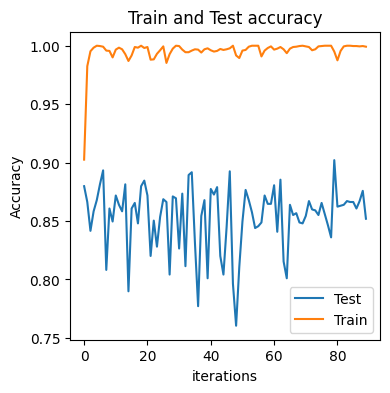

In [14]:
plt.figure(figsize=(4,4))
plt.title("Train and Test accuracy")
plt.plot(Val_accuracy,label="Test")
plt.plot(Train_accuracy,label="Train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

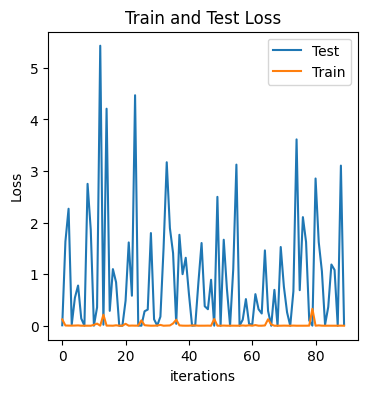

In [15]:
plt.figure(figsize=(4,4))
plt.title("Train and Test Loss")
plt.plot(Val_loss,label="Test")
plt.plot(Train_loss,label="Train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
print("Mean Train loss", (sum(Train_loss)/ len(Train_loss)))
print("Mean Test loss ", (sum(Val_loss)/len(Val_loss)))
print("Mean Train acc", (sum(Train_accuracy)/len(Train_accuracy)))
print("Mean Test acc", (sum(Val_accuracy)/len(Val_accuracy)))

Mean Train loss 0.014482465941641307
Mean Test loss  1.3925214520730809
Mean Train acc 0.9952746913580248
Mean Test acc 0.8495399858457185


# Best model evaluation-

In [20]:
checkpoint = torch.load("Best_combined_loss_onA(time)_140")
model = convnet().to(device)
model.load_state_dict(checkpoint)
model.eval()

convnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1048576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [21]:
from time import time
pred_l = np.array([])
target = np.array([])
accuracy = np.array([])
model.eval()

for batch in test_dl:
    acc = 0
    start = time()
    x_test, y_test = batch
    x_test = x_test.to(device)
    prob = model(x_test)
    pred = torch.max(prob,1).indices
    pred = pred.cpu()
    acc += int(torch.sum(pred == y_test))

    accuracy = np.append(accuracy, acc/len(y_test))
    pred = pred.cpu().data.numpy()
    y_test = y_test.data.numpy()
    pred_l=np.append(pred_l, pred)
    target=np.append(target, y_test)
    end = time()
    Test_duration = (end - start)

print("Time taken for Testing", Test_duration)

Time taken for Testing 0.009542226791381836


In [22]:
print(np.mean(accuracy))

0.87734375


In [23]:
from sklearn.metrics import classification_report
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(target, pred_l, target_names=target_names))

              precision    recall  f1-score   support

      NORMAL       0.97      0.75      0.85       571
   PNEUMONIA       0.83      0.98      0.90       685

    accuracy                           0.88      1256
   macro avg       0.90      0.87      0.87      1256
weighted avg       0.89      0.88      0.87      1256



In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target, pred_l)
print(cm)

[[430 141]
 [ 13 672]]


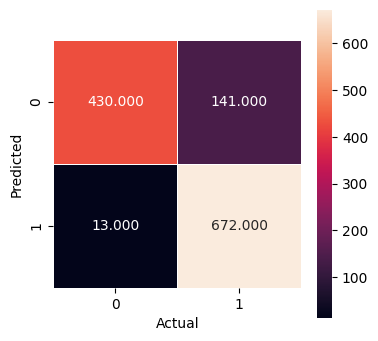

In [25]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure(figsize = (4,4))
sb.heatmap(cm, annot=True, fmt="0.3f", linewidths=0.5, square=True, cbar=True)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

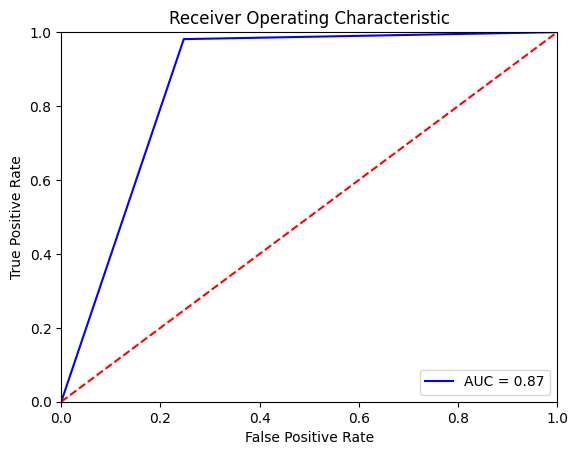

In [26]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(target, pred_l)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature extraction-

In [25]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [26]:
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 3


In [27]:
image, label = train_ds[1000]
print(image.shape)
print(label)

torch.Size([3, 512, 512])
1


In [28]:
image = image.unsqueeze(0)
print(image.shape)
image = image.to(device)

torch.Size([1, 3, 512, 512])


In [29]:
# pass the image through all the layers
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([16, 512, 512])


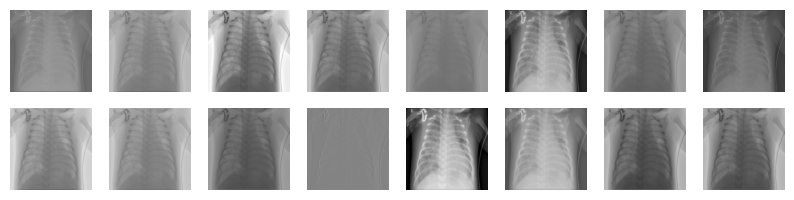

torch.Size([32, 512, 512])


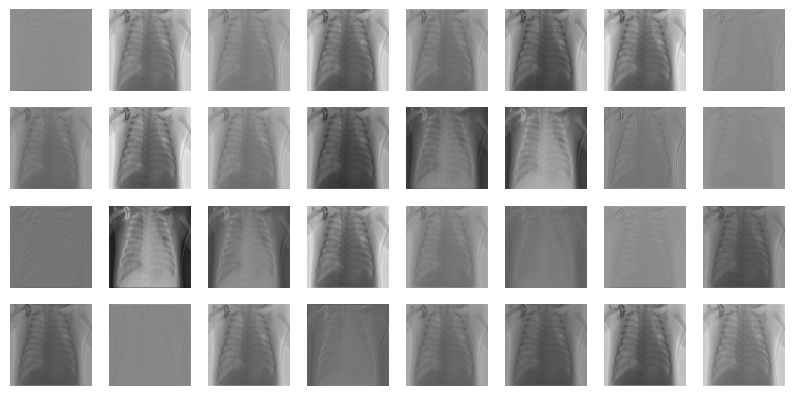

torch.Size([64, 512, 512])


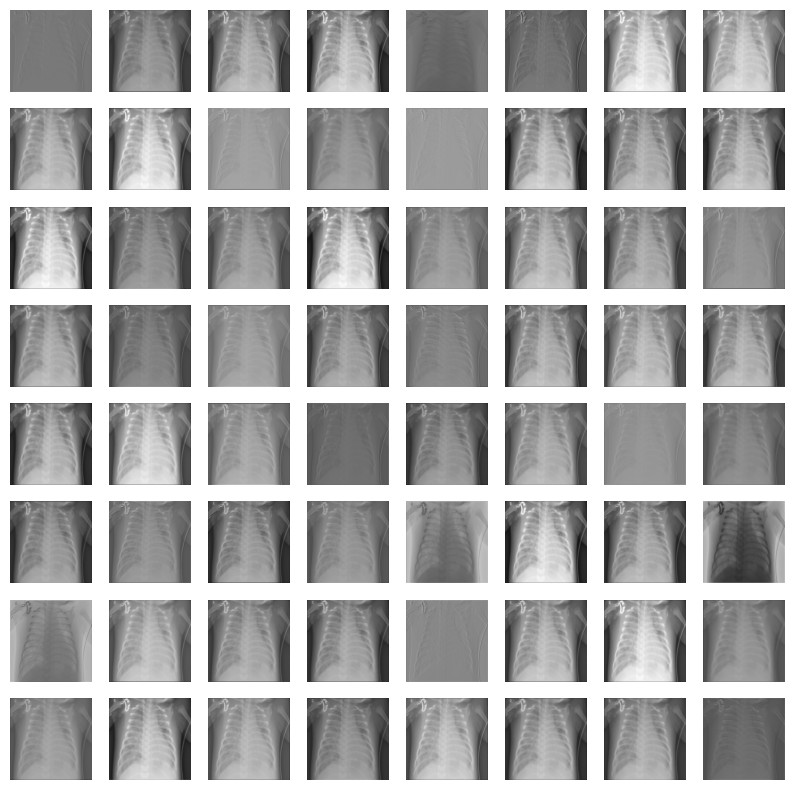

In [30]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(10,10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
#     print(f"Saving layer {num_layer} feature maps...")
#     plt.savefig(/home/kusum/Dekstop/Feature_map/ + str{num_layer} +".png")
    plt.show()
    plt.close()